<a href="https://colab.research.google.com/github/fireball412/colab_experiments/blob/main/keras_frsky_voltage_current_throttle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Battery model

script adapted from TinyML code example

## Configure Defaults

In [1]:
# Define paths to model files
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

## Setup Environment

Install Dependencies

In [2]:
#! pip install tensorflow==2.4.0rc0

Import Dependencies

In [3]:
# TensorFlow is an open source machine learning library
import tensorflow as tf

# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras
# Numpy is a math library
import numpy as np
# Pandas is a data manipulation library 
import pandas as pd
# Matplotlib is a graphing library
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
# Math is Python's math library
import math

# Set seed for experiment reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)





## Dataset

### 1. Import Data

In [4]:
#for local file upload

#from google.colab import files 
#uploaded = files.upload()

In [5]:
import pandas as pd 
import io 

#for local file upload instead of github
#df = pd.read_csv(io.BytesIO(uploaded['Explorer-2020-11-28.csv'])) 

url1 = 'https://raw.githubusercontent.com/fireball412/colab_experiments/main/Explorer-2020-11-28.csv'
url2 = 'https://raw.githubusercontent.com/fireball412/colab_experiments/main/Explorer-2020-12-05.csv'
df1 = pd.read_csv(url1)
df2 = pd.read_csv(url2)

df=df1
df=df.append(df2)

df=df1
print(df)


             Date          Time  RSSI(dB)  ...  SH                 LSW  TxBat(V)
0      2020-11-28  13:12:43.310         0  ...  -1  0x0000000000000000      10.0
1      2020-11-28  13:12:43.380         0  ...  -1  0x0000000000000000      10.0
2      2020-11-28  13:12:43.480         0  ...  -1  0x0000000000000000      10.0
3      2020-11-28  13:12:43.580         0  ...  -1  0x0000000000000000      10.0
4      2020-11-28  13:12:43.680         0  ...  -1  0x0000000000000000      10.0
...           ...           ...       ...  ...  ..                 ...       ...
16932  2020-11-28  18:27:36.930         0  ...  -1  0x0000000000000000      10.0
16933  2020-11-28  18:27:37.030         0  ...  -1  0x0000000000000000      10.0
16934  2020-11-28  18:27:37.130         0  ...  -1  0x0000000000000000      10.0
16935  2020-11-28  18:27:37.230         0  ...  -1  0x0000000000000000      10.0
16936  2020-11-28  18:27:37.330         0  ...  -1  0x0000000000000000      10.0

[16937 rows x 26 columns]


https://towardsdatascience.com/extract-rows-columns-from-a-dataframe-in-python-r-678e5b6743d6

In [6]:
print(df.iloc[0])

Date                2020-11-28
Time              13:12:43.310
RSSI(dB)                     0
RxBt(V)                      0
Cels(V)                      0
Curr(A)                      0
Cap(mAh)                  1378
Rud                         -2
Ele                          2
Thr                      -1021
Ail                         11
S1                        -732
S2                         341
S3                         379
LS                        -450
RS                        -135
SA                           0
SB                           0
SC                           0
SD                           0
SE                           0
SF                           1
SG                           0
SH                          -1
LSW         0x0000000000000000
TxBat(V)                    10
Name: 0, dtype: object


(16937, 26)

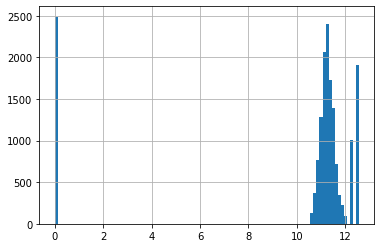

In [7]:
# drop rows with abnormal data.
#https://www.justintodata.com/data-cleaning-python-ultimate-guide/
LOWVOL=-5
HIGHVOL=16
ind_lowvol = df[df['Cels(V)'] < LOWVOL].index
df_nolowvol = df.drop(ind_lowvol, axis=0)

ind_highvol = df[df['Cels(V)'] > HIGHVOL].index
df_nolowvol_nohighvol = df_nolowvol.drop(ind_highvol, axis=0)

df_nolowvol_nohighvol['Cels(V)'].hist(bins=100)
df_nolowvol_nohighvol['Cels(V)'].describe()

df=df_nolowvol_nohighvol
np.shape(df)

(16937, 26)

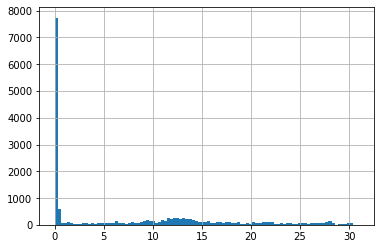

In [8]:
# drop rows with abnormal data.
#https://www.justintodata.com/data-cleaning-python-ultimate-guide/
LOWCUR=0
HIGHCUR=35
ind_lowcur = df[df['Curr(A)'] < LOWCUR].index
df_nolowcur = df.drop(ind_lowcur, axis=0)

ind_highcur = df[df['Curr(A)'] > HIGHCUR].index
df_nolowcur_nohighcur = df_nolowcur.drop(ind_highcur, axis=0)

df_nolowcur_nohighcur['Curr(A)'].hist(bins=100)
df_nolowcur_nohighcur['Curr(A)'].describe()

df=df_nolowcur_nohighcur
np.shape(df)


### 2. Select Data

[-1.022 -1.022 -1.022 ... -1.018 -1.018 -1.018]
[0.005 0.005 0.005 ... 0.002 0.002 0.002]
[0.007 0.007 0.008 ... 1.362 1.362 1.362]
[1.229 1.229 1.229 ... 1.117 1.117 1.117]


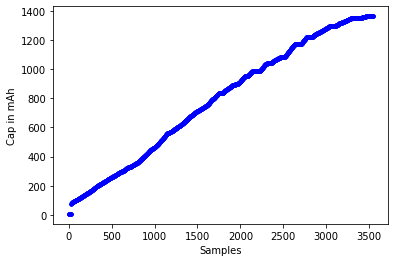

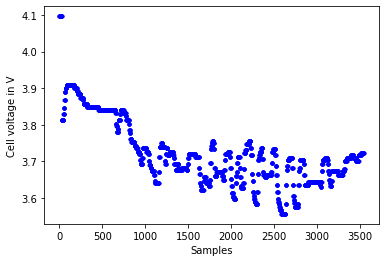

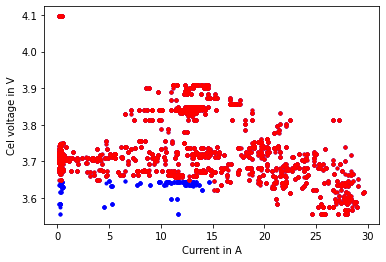

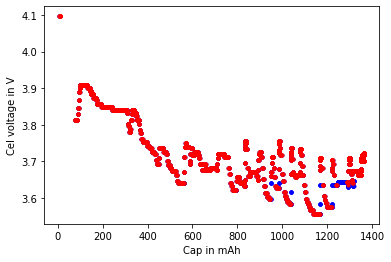

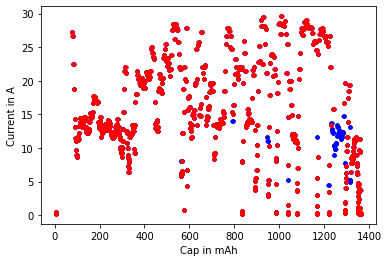

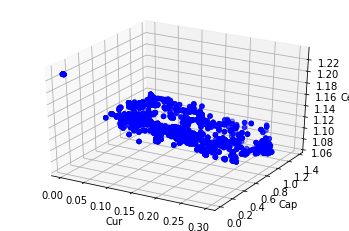

In [9]:
#select data for modelling
INDEX_START=2385
INDEX_STOP=5931
#INDEX_START=1
#INDEX_STOP=22000
SAMPLES=INDEX_STOP-INDEX_START

#scaling for telemetry data to get close to 1
SCALE_THR=1000
SCALE_CUR=100
SCALE_CAP=1000
SCALE_VOL=10
NUM_CEL=3
NOM_CAP=2200
SAMPLE_RATE=0.1

#throttle 
thr_values=df.iloc[INDEX_START:INDEX_STOP,9]
thr_values=thr_values.to_numpy()/SCALE_THR
print(thr_values)

#current
cur_values=df.iloc[INDEX_START:INDEX_STOP,5]
cur_values=cur_values.to_numpy()/SCALE_CUR 
print(cur_values)

#cap(mAh)
cap_values=df.iloc[INDEX_START:INDEX_STOP,6]
cap_values=cap_values.to_numpy()/SCALE_CAP 
print(cap_values)

#cels(V)
cel_values=df.iloc[INDEX_START:INDEX_STOP,4]
cel_values=cel_values.to_numpy()/SCALE_VOL 
print(cel_values)

CUR_MIN_LOW_VOL=15
VOL_MIN_LOW_CUR=3.65
skip_vec=np.linspace(1, 1, SAMPLES)
for i in range(SAMPLES):
  if cel_values[i]*SCALE_VOL/NUM_CEL<VOL_MIN_LOW_CUR and cur_values[i]*SCALE_CUR<CUR_MIN_LOW_VOL:
    skip_vec[i]=0

skip_vec = np.array(skip_vec,dtype='bool')

cur_values_clean=cur_values[skip_vec]
cap_values_clean=cap_values[skip_vec]
cel_values_clean=cel_values[skip_vec]

# Plot capacity
plt.plot(cap_values*SCALE_CAP, 'b.')
plt.xlabel('Samples')
plt.ylabel('Cap in mAh')
plt.show()

# Plot voltage
plt.plot(cel_values*SCALE_VOL/NUM_CEL, 'b.')
plt.xlabel('Samples')
plt.ylabel('Cell voltage in V')
plt.show()


# Plot vol vs. cur
plt.plot(cur_values*SCALE_CUR, cel_values*SCALE_VOL/NUM_CEL, 'b.')
plt.plot(cur_values_clean*SCALE_CUR, cel_values_clean*SCALE_VOL/NUM_CEL, 'r.')
plt.xlabel('Current in A')
plt.ylabel('Cel voltage in V')
plt.show()

# Plot vol vs. cap
plt.plot(cap_values*SCALE_CAP, cel_values*SCALE_VOL/NUM_CEL, 'b.')
plt.plot(cap_values_clean*SCALE_CAP, cel_values_clean*SCALE_VOL/NUM_CEL, 'r.')
plt.xlabel('Cap in mAh')
plt.ylabel('Cel voltage in V')
plt.show()

# Plot Cap vs. cur
plt.plot(cap_values*SCALE_CAP, cur_values*SCALE_CUR, 'b.')
plt.plot(cap_values_clean*SCALE_CAP, cur_values_clean*SCALE_CUR, 'r.')
plt.xlabel('Cap in mAh')
plt.ylabel('Current in A')
plt.show()

fig = plt.figure()
ax = plt.axes(projection="3d")
x = cur_values
y = cap_values
z = cel_values
ax.scatter(x,y,z,color='b')
ax.set_xlabel('Cur')
ax.set_ylabel('Cap')
ax.set_zlabel('Cel')
plt.show()

 
#shuffle data to avoid split of train,validate and test according to flight time
temp = list(zip(cur_values_clean, cap_values_clean, cel_values_clean)) 
np.random.shuffle(temp) 
cur_values_clean, cap_values_clean, cel_values_clean = zip(*temp)

cur_values_clean=np.array(cur_values_clean)
cap_values_clean=np.array(cap_values_clean)
cel_values_clean=np.array(cel_values_clean)

#define data for modelling
x_values=np.vstack((cur_values_clean,cap_values_clean))
x_values=np.transpose(x_values)
y_values=cel_values_clean


### 3. Split the Data
The data is split as follows:
Training: 60%
Validation: 20%
Testing: 20%

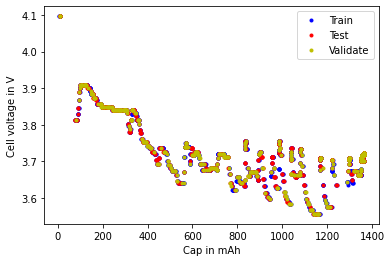

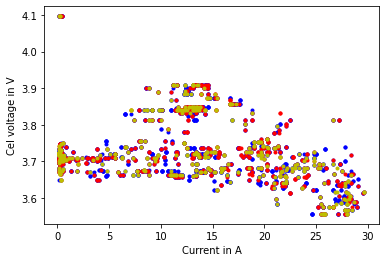

In [10]:
# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
#x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

#x_train=x_values[:,:TRAIN_SPLIT]
#x_test=x_values[:,TRAIN_SPLIT:TEST_SPLIT]
#x_validate=x_values[:,TEST_SPLIT:]

x_train=x_values[:TRAIN_SPLIT,:]
x_test=x_values[TRAIN_SPLIT:TEST_SPLIT,:]
x_validate=x_values[TEST_SPLIT:,:]

#y_train=y_values[:,:TRAIN_SPLIT]
#y_test=y_values[:,TRAIN_SPLIT:TEST_SPLIT]
#y_validate=y_values[:,TEST_SPLIT:]

# Plot vol vs. cap
plt.plot(x_train[:,1]*SCALE_CAP, y_train*SCALE_VOL/NUM_CEL, 'b.', label="Train")
plt.plot(x_test[:,1]*SCALE_CAP, y_test*SCALE_VOL/NUM_CEL, 'r.', label="Test")
plt.plot(x_validate[:,1]*SCALE_CAP, y_validate*SCALE_VOL/NUM_CEL, 'y.', label="Validate")
plt.legend()
plt.xlabel('Cap in mAh')
plt.ylabel('Cell voltage in V')
plt.show()

# Plot vol vs. cur
plt.plot(x_train[:,0]*SCALE_CUR, y_train*SCALE_VOL/NUM_CEL, 'b.')
plt.plot(x_test[:,0]*SCALE_CUR, y_test*SCALE_VOL/NUM_CEL, 'r.', label="Test")
plt.plot(x_validate[:,0]*SCALE_CUR, y_validate*SCALE_VOL/NUM_CEL, 'y.', label="Validate")
plt.xlabel('Current in A')
plt.ylabel('Cel voltage in V')
plt.show()






## Training



### 1. Design the model

We're going to build a simple neural network model that will take an input value (in this case throttle) and use it to predict a numeric output value (current). This type of problem is called a regression. It will use layers of neurons to attempt to learn any patterns underlying the training data, so it can make predictions.

To begin with, we'll define two layers. The first layer takes a single input (our x value) and runs it through 16 neurons. Based on this input, each neuron will become activated to a certain degree based on its internal state (its weight and bias values). A neuron's degree of activation is expressed as a number.

The activation numbers from our first layer will be fed as inputs to our second layer, which is a single neuron. It will apply its own weights and bias to these inputs and calculate its own activation, which will be output as our y value.

Note: To learn more about how neural networks function, you can explore the Learn TensorFlow codelabs.

The code in the following cell defines our model using Keras, TensorFlow's high-level API for creating deep learning networks. Once the network is defined, we compile it, specifying parameters that determine how it will be trained:

In [11]:
model1 = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 16 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model1.add(keras.layers.Dense(16, activation='relu', input_shape=(2,)))

# The new second and third layer will help the network learn more complex representations
model1.add(keras.layers.Dense(16, activation='relu'))

# Final layer is a single neuron, since we want to output a single value
model1.add(keras.layers.Dense(1))

# Compile the model using the standard 'adam' optimizer and the mean squared error or 'mse' loss function for regression.
model1.compile(optimizer='adam', loss="mse", metrics=["mae"])


In [12]:
model1 = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 16 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model1.add(keras.layers.Dense(16, activation='relu', input_shape=(2,)))

# The new second and third layer will help the network learn more complex representations
model1.add(keras.layers.Dense(16, activation='relu'))
model1.add(keras.layers.Dense(16, activation='relu'))
model1.add(keras.layers.Dense(16, activation='relu'))

# Final layer is a single neuron, since we want to output a single value
model1.add(keras.layers.Dense(1))

# Compile the model using the standard 'adam' optimizer and the mean squared error or 'mse' loss function for regression.
model1.compile(optimizer='adam', loss="mse", metrics=["mae"])

#save initial weights
initial_weights1 = model1.get_weights()


In [13]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                48        
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 881
Trainable params: 881
Non-trainable params: 0
_________________________________________________________________


In [14]:
#restore initial weights if required
model1.set_weights(initial_weights1)

### 2. Train the Model
Once we've defined the model, we can use our data to _train_ it. Training involves passing an `x` value into the neural network, checking how far the network's output deviates from the expected `y` value, and adjusting the neurons' weights and biases so that the output is more likely to be correct the next time.

Training runs this process on the full dataset multiple times, and each full run-through is known as an _epoch_. The number of epochs to run during training is a parameter we can set.

During each epoch, data is run through the network in multiple _batches_. Each batch, several pieces of data are passed into the network, producing output values. These outputs' correctness is measured in aggregate and the network's weights and biases are adjusted accordingly, once per batch. The _batch size_ is also a parameter we can set.

The code in the following cell uses the `x` and `y` values from our training data to train the model. It runs for 200 _epochs_, with 64 pieces of data in each _batch_. We also pass in some data for _validation_. As you will see when you run the cell, training can take a while to complete:

In [15]:
# Train the model
history1 = model1.fit(x_train, y_train, epochs=100, batch_size=64,
                    validation_data=(x_validate, y_validate))

# Save the model to disk
model1.save(MODEL_TF)


Epoch 1/100
34/34 [==============================] - 1s 17ms/step - loss: 0.9635 - mae: 0.9727 - val_loss: 0.2299 - val_mae: 0.4685
Epoch 2/100
34/34 [==============================] - 0s 3ms/step - loss: 0.1099 - mae: 0.2857 - val_loss: 0.0178 - val_mae: 0.1115
Epoch 3/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0122 - mae: 0.0912 - val_loss: 0.0067 - val_mae: 0.0691
Epoch 4/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0059 - mae: 0.0652 - val_loss: 0.0047 - val_mae: 0.0570
Epoch 5/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0044 - mae: 0.0547 - val_loss: 0.0039 - val_mae: 0.0507
Epoch 6/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0039 - mae: 0.0507 - val_loss: 0.0034 - val_mae: 0.0475
Epoch 7/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0032 - mae: 0.0466 - val_loss: 0.0028 - val_mae: 0.0429
Epoch 8/100
34/34 [==============================] - 0s 2ms/step - loss: 0.0027 - 

### 3. Plot Metrics
Each training epoch, the model prints out its loss and mean absolute error for training and validation. You can read this in the output above (note that your exact numbers may differ): 

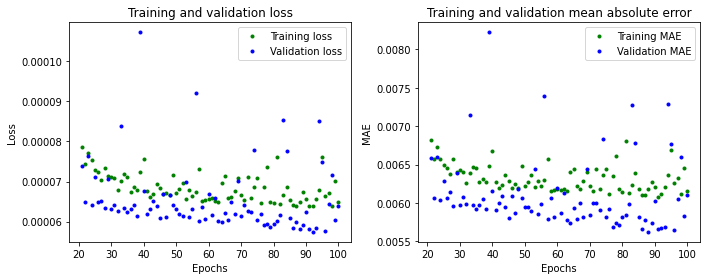

In [16]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Exclude the first few epochs so the graph is easier to read
SKIP = 20

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
train_mae = history1.history['mae']
val_mae = history1.history['val_mae']

plt.plot(epochs[SKIP:], train_mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()

23/23 [==============================] - 0s 1ms/step - loss: 7.3072e-05 - mae: 0.0066


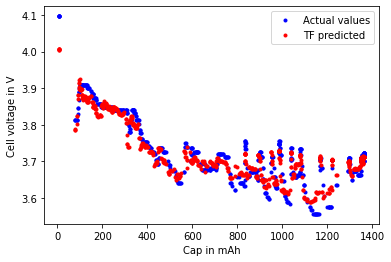

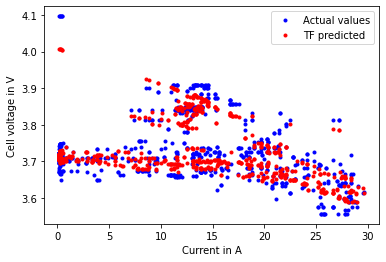

In [17]:
# Calculate and print the loss on our test dataset
test_loss, test_mae = model1.evaluate(x_test, y_test)

# Make predictions based on our test dataset
y_test_pred = model1.predict(x_test)

# Plot vol vs. cap
plt.plot(x_test[:,1]*SCALE_CAP, y_test*SCALE_VOL/NUM_CEL, 'b.', label='Actual values')
plt.plot(x_test[:,1]*SCALE_CAP, y_test_pred*SCALE_VOL/NUM_CEL, 'r.', label='TF predicted')
plt.legend()
plt.xlabel('Cap in mAh')
plt.ylabel('Cell voltage in V')
plt.show()

# Plot vol vs. cap
plt.plot(x_test[:,0]*SCALE_CUR, y_test*SCALE_VOL/NUM_CEL, 'b.', label='Actual values')
plt.plot(x_test[:,0]*SCALE_CUR, y_test_pred*SCALE_VOL/NUM_CEL, 'r.', label='TF predicted')
plt.legend()
plt.xlabel('Current in A')
plt.ylabel('Cell voltage in V')
plt.show()

## Evaluate

the model can be used to predict the discharge curve and internal resistance
https://www.richtek.com/~/media/Richtek/Design%20Support/Technical%20Documentation/AN025/EN/Version3/image003.jpg?file=preview.png




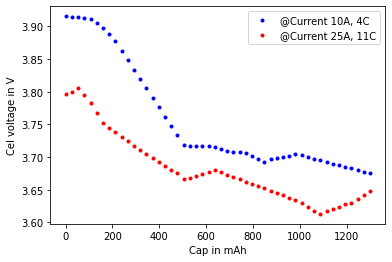

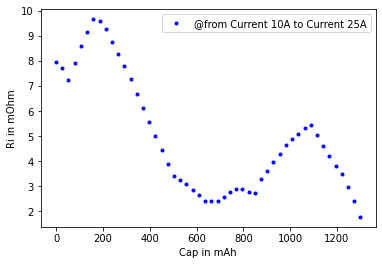

In [18]:
#current value 1
TEST_CUR1=10
TEST_SAMPLES1=50
TEST_CAP1=1300
cur_vec=np.linspace(TEST_CUR1, TEST_CUR1, TEST_SAMPLES1)/SCALE_CUR
cap_vec=np.linspace(0, TEST_CAP1, TEST_SAMPLES1)/SCALE_CAP
x_test_real1=np.vstack((cur_vec,cap_vec))
x_test_real1=np.transpose(x_test_real1)
y_test_real1 = model1.predict(x_test_real1)

#current value 2
TEST_CUR2=25
TEST_SAMPLES2=50
TEST_CAP2=1300
cur_vec=np.linspace(TEST_CUR2, TEST_CUR2, TEST_SAMPLES2)/SCALE_CUR
cap_vec=np.linspace(0, TEST_CAP2, TEST_SAMPLES2)/SCALE_CAP
x_test_real2=np.vstack((cur_vec,cap_vec))
x_test_real2=np.transpose(x_test_real2)
y_test_real2 = model1.predict(x_test_real2)

# Plot vol vs. cap
plt.plot(x_test_real1[:,1]*SCALE_CAP, y_test_real1*SCALE_VOL/NUM_CEL, 'b.', label='@Current '+str(TEST_CUR1)+'A, '+str(int(TEST_CUR1/NOM_CAP*1000)) +'C')
plt.plot(x_test_real2[:,1]*SCALE_CAP, y_test_real2*SCALE_VOL/NUM_CEL, 'r.', label='@Current '+str(TEST_CUR2)+'A, '+str(int(TEST_CUR2/NOM_CAP*1000)) +'C')
plt.legend()
plt.xlabel('Cap in mAh')
plt.ylabel('Cel voltage in V')
plt.show()

# Plot Ri vs cap
y_ri=-(y_test_real2-y_test_real1)/(TEST_CUR2-TEST_CUR1)
plt.plot(x_test_real1[:,1]*SCALE_CAP, y_ri*SCALE_VOL/NUM_CEL*1000, 'b.', label='@from Current '+str(TEST_CUR1)+'A to Current '+str(TEST_CUR2)+'A')
plt.legend()
plt.xlabel('Cap in mAh')
plt.ylabel('Ri in mOhm')
plt.show()



# Drive model

## Dataset

### 1. Import Data

In [19]:
#import pandas as pd 
#import io 

#for local file upload instead of github
#df = pd.read_csv(io.BytesIO(uploaded['Explorer-2020-11-28.csv'])) 

#url1 = 'https://raw.githubusercontent.com/fireball412/colab_experiments/main/Explorer-2020-11-28.csv'
#url2 = 'https://raw.githubusercontent.com/fireball412/colab_experiments/main/Explorer-2020-12-05.csv'
#df1 = pd.read_csv(url1)
#df2 = pd.read_csv(url2)

df=df1
#df=df.append(df2)
print(df)



             Date          Time  RSSI(dB)  ...  SH                 LSW  TxBat(V)
0      2020-11-28  13:12:43.310         0  ...  -1  0x0000000000000000      10.0
1      2020-11-28  13:12:43.380         0  ...  -1  0x0000000000000000      10.0
2      2020-11-28  13:12:43.480         0  ...  -1  0x0000000000000000      10.0
3      2020-11-28  13:12:43.580         0  ...  -1  0x0000000000000000      10.0
4      2020-11-28  13:12:43.680         0  ...  -1  0x0000000000000000      10.0
...           ...           ...       ...  ...  ..                 ...       ...
16932  2020-11-28  18:27:36.930         0  ...  -1  0x0000000000000000      10.0
16933  2020-11-28  18:27:37.030         0  ...  -1  0x0000000000000000      10.0
16934  2020-11-28  18:27:37.130         0  ...  -1  0x0000000000000000      10.0
16935  2020-11-28  18:27:37.230         0  ...  -1  0x0000000000000000      10.0
16936  2020-11-28  18:27:37.330         0  ...  -1  0x0000000000000000      10.0

[16937 rows x 26 columns]


https://towardsdatascience.com/extract-rows-columns-from-a-dataframe-in-python-r-678e5b6743d6

In [20]:
print(df.iloc[0])

Date                2020-11-28
Time              13:12:43.310
RSSI(dB)                     0
RxBt(V)                      0
Cels(V)                      0
Curr(A)                      0
Cap(mAh)                  1378
Rud                         -2
Ele                          2
Thr                      -1021
Ail                         11
S1                        -732
S2                         341
S3                         379
LS                        -450
RS                        -135
SA                           0
SB                           0
SC                           0
SD                           0
SE                           0
SF                           1
SG                           0
SH                          -1
LSW         0x0000000000000000
TxBat(V)                    10
Name: 0, dtype: object


(16937, 26)

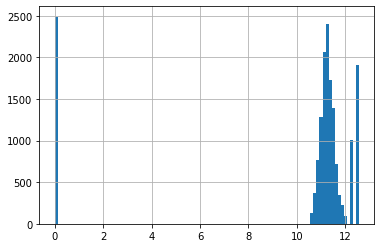

In [21]:
# drop rows with abnormal data.
#https://www.justintodata.com/data-cleaning-python-ultimate-guide/
LOWVOL=-5
HIGHVOL=16
ind_lowvol = df[df['Cels(V)'] < LOWVOL].index
df_nolowvol = df.drop(ind_lowvol, axis=0)

ind_highvol = df[df['Cels(V)'] > HIGHVOL].index
df_nolowvol_nohighvol = df_nolowvol.drop(ind_highvol, axis=0)

df_nolowvol_nohighvol['Cels(V)'].hist(bins=100)
df_nolowvol_nohighvol['Cels(V)'].describe()

df=df_nolowvol_nohighvol
np.shape(df)

(16937, 26)

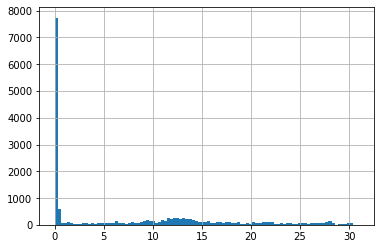

In [22]:
# drop rows with abnormal data.
#https://www.justintodata.com/data-cleaning-python-ultimate-guide/
LOWCUR=0
HIGHCUR=35
ind_lowcur = df[df['Curr(A)'] < LOWCUR].index
df_nolowcur = df.drop(ind_lowcur, axis=0)

ind_highcur = df[df['Curr(A)'] > HIGHCUR].index
df_nolowcur_nohighcur = df_nolowcur.drop(ind_highcur, axis=0)

df_nolowcur_nohighcur['Curr(A)'].hist(bins=100)
df_nolowcur_nohighcur['Curr(A)'].describe()

df=df_nolowcur_nohighcur
np.shape(df)


### 2. Select Data

[-1.022 -1.022 -1.022 ... -1.018 -1.018 -1.018]
[0.005 0.005 0.005 ... 0.002 0.002 0.002]
[0.007 0.007 0.008 ... 1.362 1.362 1.362]


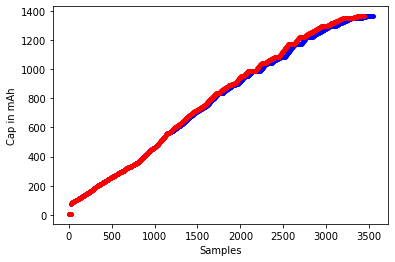

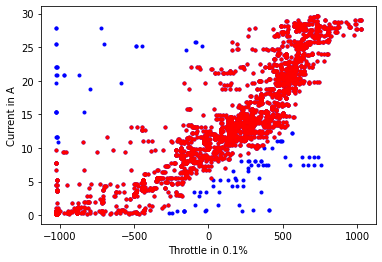

In [23]:
#select data for modelling
INDEX_START=2385
INDEX_STOP=5931
SAMPLES2=INDEX_STOP-INDEX_START

#scaling for telemetry data to get close to 1
#from battery model

#throttle 
thr_values=df.iloc[INDEX_START:INDEX_STOP,9]
thr_values=thr_values.to_numpy()/SCALE_THR
print(thr_values)

#current
cur_values=df.iloc[INDEX_START:INDEX_STOP,5]
cur_values=cur_values.to_numpy()/SCALE_CUR 
print(cur_values)

#cap(mAh)
cap_values=df.iloc[INDEX_START:INDEX_STOP,6]
cap_values=cap_values.to_numpy()/SCALE_CAP 
print(cap_values)

CUR_LIN_DEV_MAX=10
skip_vec=np.linspace(1, 1, SAMPLES2)
lin_vec=np.linspace(0, 0, SAMPLES2)
for i in range(SAMPLES2):
  lin_vec[i]=(max(cur_values)-min(cur_values))/(max(thr_values)-min(thr_values))*(thr_values[i]-min(thr_values))+min(cur_values)
  if abs(cur_values[i]-lin_vec[i])>CUR_LIN_DEV_MAX/SCALE_CUR:
    skip_vec[i]=0

skip_vec = np.array(skip_vec,dtype='bool')

thr_values_clean=thr_values[skip_vec]
cur_values_clean=cur_values[skip_vec]
cap_values_clean=cap_values[skip_vec]

# Plot capacity
plt.plot(cap_values*SCALE_CAP, 'b.')
plt.plot(cap_values_clean*SCALE_CAP, 'r.')
plt.xlabel('Samples')
plt.ylabel('Cap in mAh')
plt.show()

# Plot current vs. throttle
plt.plot(thr_values*SCALE_THR, cur_values*SCALE_CUR, 'b.')
plt.plot(thr_values_clean*SCALE_THR, cur_values_clean*SCALE_CUR, 'r.')
plt.xlabel('Throttle in 0.1%')
plt.ylabel('Current in A')
plt.show()

#shuffle data to avoid split of train,validate and test according to flight time
temp = list(zip(thr_values_clean, cur_values_clean, cap_values_clean)) 
np.random.shuffle(temp) 
thr_values_clean, cur_values_clean, cap_values_clean = zip(*temp)

thr_values_clean=np.array(thr_values_clean)
cur_values_clean=np.array(cur_values_clean)
cap_values_clean=np.array(cap_values_clean)


#define data for modelling
#x_values=np.vstack((cur_values,cap_values))
#x_values=np.transpose(x_values)
x_values2=thr_values_clean
y_values2=cur_values_clean
y_sup_values2=cap_values_clean


### 3. Split the Data
The data is split as follows:
Training: 60%
Validation: 20%
Testing: 20%

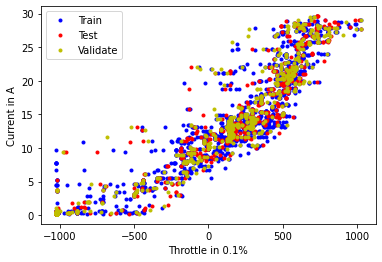

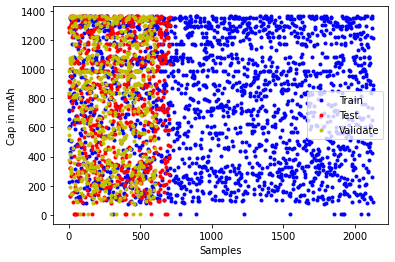

In [24]:
# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
TRAIN_SPLIT =  int(0.6 * SAMPLES2)
TEST_SPLIT = int(0.2 * SAMPLES2 + TRAIN_SPLIT)

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
x_train2, x_test2, x_validate2 = np.split(x_values2, [TRAIN_SPLIT, TEST_SPLIT])
y_train2, y_test2, y_validate2 = np.split(y_values2, [TRAIN_SPLIT, TEST_SPLIT])
y_sup_train2, y_sup_test2, y_sup_validate2 = np.split(y_sup_values2, [TRAIN_SPLIT, TEST_SPLIT])


# Plot the data in each partition in different colors:
plt.plot(x_train2*SCALE_THR, y_train2*SCALE_CUR, 'b.', label="Train")
plt.plot(x_test2*SCALE_THR, y_test2*SCALE_CUR, 'r.', label="Test")
plt.plot(x_validate2*SCALE_THR, y_validate2*SCALE_CUR, 'y.', label="Validate")
plt.legend()
plt.xlabel('Throttle in 0.1%')
plt.ylabel('Current in A')
plt.show()

# Plot capacity to check if data is scrambled and not ordered 
plt.plot(y_sup_train2*SCALE_CAP, 'b.', label="Train")
plt.plot(y_sup_test2*SCALE_CAP, 'r.', label="Test")
plt.plot(y_sup_validate2*SCALE_CAP, 'y.', label="Validate")
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Cap in mAh')
plt.show()



## Training

### 1. Design the model

In [25]:
model2 = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 16 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model2.add(keras.layers.Dense(16, activation='relu', input_shape=(1,)))

# The new second and third layer will help the network learn more complex representations
model2.add(keras.layers.Dense(16, activation='relu'))

# Final layer is a single neuron, since we want to output a single value
model2.add(keras.layers.Dense(1))

# Compile the model using the standard 'adam' optimizer and the mean squared error or 'mse' loss function for regression.
model2.compile(optimizer='adam', loss="mse", metrics=["mae"])


In [26]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 16)                32        
_________________________________________________________________
dense_9 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 17        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


### 2. Train the Model

In [27]:
# Train the model
history2 = model2.fit(x_train2, y_train2, epochs=200, batch_size=64,validation_data=(x_validate2, y_validate2))

# Save the model to disk
#model2.save(MODEL_TF)

Epoch 1/200
34/34 [==============================] - 1s 7ms/step - loss: 0.0342 - mae: 0.1573 - val_loss: 0.0016 - val_mae: 0.0338
Epoch 2/200
34/34 [==============================] - 0s 2ms/step - loss: 0.0014 - mae: 0.0316 - val_loss: 0.0010 - val_mae: 0.0234
Epoch 3/200
34/34 [==============================] - 0s 2ms/step - loss: 8.5490e-04 - mae: 0.0220 - val_loss: 8.2935e-04 - val_mae: 0.0199
Epoch 4/200
34/34 [==============================] - 0s 2ms/step - loss: 7.6067e-04 - mae: 0.0201 - val_loss: 8.0540e-04 - val_mae: 0.0190
Epoch 5/200
34/34 [==============================] - 0s 2ms/step - loss: 7.0839e-04 - mae: 0.0191 - val_loss: 7.8900e-04 - val_mae: 0.0185
Epoch 6/200
34/34 [==============================] - 0s 2ms/step - loss: 6.4505e-04 - mae: 0.0179 - val_loss: 7.7982e-04 - val_mae: 0.0182
Epoch 7/200
34/34 [==============================] - 0s 2ms/step - loss: 6.8651e-04 - mae: 0.0186 - val_loss: 7.6365e-04 - val_mae: 0.0178
Epoch 8/200
34/34 [========================

### 3. Plot Metrics

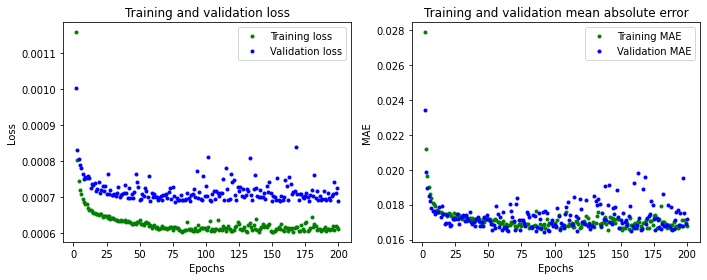

In [28]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Exclude the first few epochs so the graph is easier to read
SKIP = 1

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
train_mae = history2.history['mae']
val_mae = history2.history['val_mae']

plt.plot(epochs[SKIP:], train_mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()

23/23 [==============================] - 0s 1ms/step - loss: 6.0653e-04 - mae: 0.0169


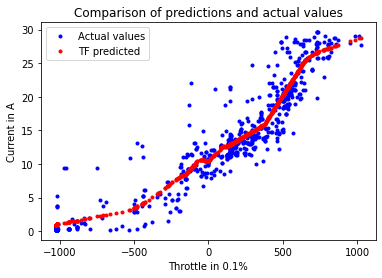

In [29]:
# Calculate and print the loss on our test dataset
test_loss, test_mae = model2.evaluate(x_test2, y_test2)

# Make predictions based on our test dataset
y_test_pred2 = model2.predict(x_test2)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test2*SCALE_THR, y_test2*SCALE_CUR, 'b.', label='Actual values')
plt.plot(x_test2*SCALE_THR, y_test_pred2*SCALE_CUR, 'r.', label='TF predicted')
plt.legend()
plt.xlabel('Throttle in 0.1%')
plt.ylabel('Current in A')
plt.show()

## Evaluate

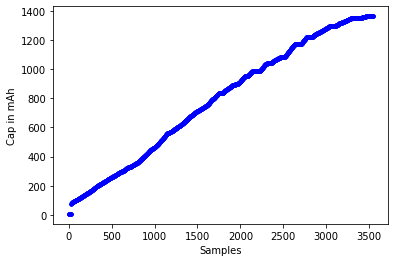

In [30]:
# my log file contained several flights
#fligth2
INDEX_START=6610
INDEX_STOP=10510

#fligth3
INDEX_START=13006
INDEX_STOP=15521

#fligth1
INDEX_START=2385
INDEX_STOP=5931

#throttle 
x_real2=df.iloc[INDEX_START:INDEX_STOP,9]
x_real2=x_real2.to_numpy()/1000 
#print(x_values)

#current
y_real2=df.iloc[INDEX_START:INDEX_STOP,5]
y_real2=y_real2.to_numpy()/100 
#print(y_values)

#cap(mAh)
y_real22=df.iloc[INDEX_START:INDEX_STOP,6]
y_real22=y_real22.to_numpy()/1000 
#print(y_values2)

# Plot capacity
plt.plot(y_real22*SCALE_CAP, 'b.')
plt.xlabel('Samples')
plt.ylabel('Cap in mAh')
plt.show()

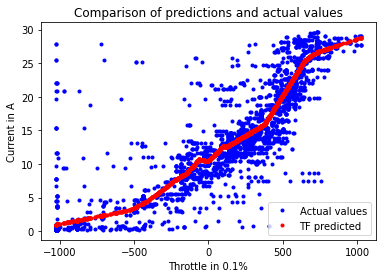

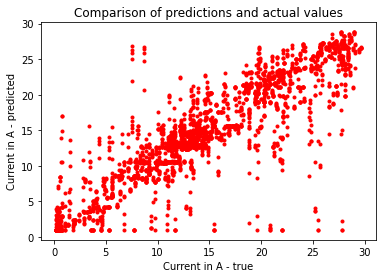

In [31]:
# Make predictions based on our test dataset
y_real_pred2 = model2.predict(x_real2)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_real2*SCALE_THR, y_real2*SCALE_CUR, 'b.', label='Actual values')
plt.plot(x_real2*SCALE_THR, y_real_pred2*SCALE_CUR, 'r.', label='TF predicted')
plt.legend()
plt.xlabel('Throttle in 0.1%')
plt.ylabel('Current in A')
plt.show()

plt.title('Comparison of predictions and actual values')
plt.plot(y_real2*SCALE_CUR, y_real_pred2*SCALE_CUR, 'r.')
plt.xlabel('Current in A - true')
plt.ylabel('Current in A - predicted')
plt.show()

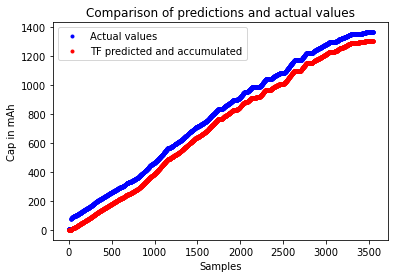

In [32]:
# integrate current
# offset errors are due to logging only during flight phase (not during take-off)
y_real_pred22=np.cumsum(y_real_pred2)*SAMPLE_RATE*1000/3600*SCALE_CUR/SCALE_CAP

plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(y_real22*SCALE_CAP, 'b.', label='Actual values')
plt.plot(y_real_pred22*SCALE_CAP, 'r.', label='TF predicted and accumulated')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Cap in mAh')
plt.show()

# Emulate

In [33]:
#initial condition
INDEX_START=2450
#INDEX_STOP=5931

#INDEX_START=6700
INDEX_STOP=10510

INDEX_START=4000
INDEX_STOP=8000

INDEX_START=2450
INDEX_STOP=5931

SAMPLES_EMU=INDEX_STOP-INDEX_START

CELL_VOL_CRITICAL=3.5
CELL_VOL_PENALITY_THRESHOLD=-0.5

time_vec=np.linspace(0, 0, SAMPLES_EMU)
#throttle controlls the emulation
thr_vec=np.linspace(0, 0, SAMPLES_EMU)
#current is predicted by model2
curr_vec=np.linspace(0, 0, SAMPLES_EMU)
curr_vec_gt=np.linspace(0, 0, SAMPLES_EMU)
#cap is calulcated by integrated current
cap_vec=np.linspace(0, 0, SAMPLES_EMU)
cap_vec_gt=np.linspace(0, 0, SAMPLES_EMU)
#cel voltage is predicted by model1
vol_vec=np.linspace(0, 0, SAMPLES_EMU)
vol_vec_gt=np.linspace(0, 0, SAMPLES_EMU)
cell_vol_error=np.linspace(0, 0, SAMPLES_EMU)
cell_vol_penality=np.linspace(0, 0, SAMPLES_EMU)
curate=np.linspace(0, 0, SAMPLES_EMU)


In [34]:
# using a 'for loop' to clearly avoid any future knowledge during prediction
# takes several minutes (why?)

time_vec[0]=0
thr_vec[0]=df.iloc[INDEX_START+0,9]/SCALE_THR
curr_vec_gt[0]=df.iloc[INDEX_START+0,5]/SCALE_CUR
curr_vec[0]=model2.predict([thr_vec[0]]).item()
cap_vec_gt[0]=df.iloc[INDEX_START+0,6]/SCALE_CAP
# initial value must be given
cap_vec[0]=df.iloc[INDEX_START+0,6]/SCALE_CAP
vol_vec_gt[0]=df.iloc[INDEX_START+0,4]/SCALE_VOL
vol_vec[0]=model1.predict([[curr_vec[0],cap_vec[0]]]).item()
curate[0]=0
print('total samples: '+str(SAMPLES_EMU))

for i in range(1,SAMPLES_EMU):
  time_vec[i]=time_vec[i-1]+SAMPLE_RATE
  thr_vec[i]=df.iloc[INDEX_START+i,9]/SCALE_THR
  curr_vec_gt[i]=df.iloc[INDEX_START+i,5]/SCALE_CUR
  curr_vec[i]=model2.predict([thr_vec[i]]).item()
  cap_vec_gt[i]=df.iloc[INDEX_START+i,6]/SCALE_CAP
  cap_vec[i]=cap_vec[i-1]+curr_vec[i]*SAMPLE_RATE*1000/3600*SCALE_CUR/SCALE_CAP
  #required to detect new flight
  if abs(cap_vec_gt[i]-cap_vec_gt[i-1])>50/SCALE_CAP:
    cap_vec[i]=cap_vec_gt[i]
  vol_vec_gt[i]=df.iloc[INDEX_START+i,4]/SCALE_VOL
  vol_vec[i]=model1.predict([[curr_vec[i],cap_vec[i]]]).item()
  cell_vol_error[i]=(vol_vec_gt[i]*SCALE_VOL/NUM_CEL-vol_vec[i]*SCALE_VOL/NUM_CEL)
  cell_vol_penality[i]=cell_vol_error[i]*1/(vol_vec_gt[i]*SCALE_VOL/NUM_CEL-CELL_VOL_CRITICAL)
  if cell_vol_penality[i]<CELL_VOL_PENALITY_THRESHOLD:
    curate[i]=1
  if i%100==0:
    print (i)




total samples: 3481
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400


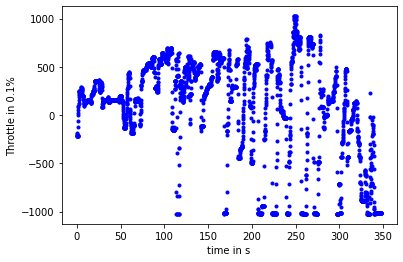

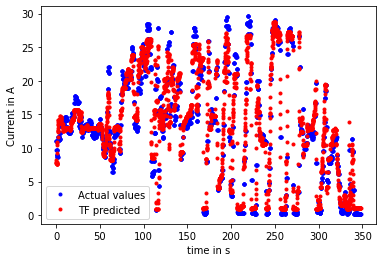

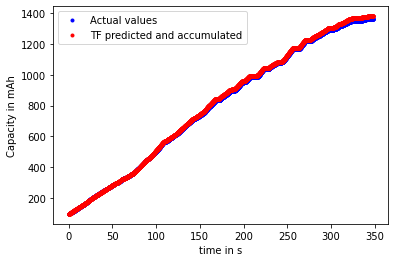

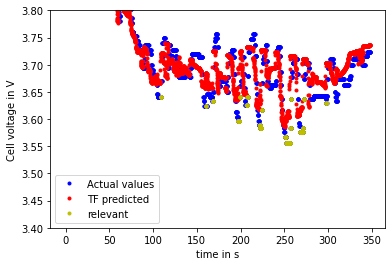

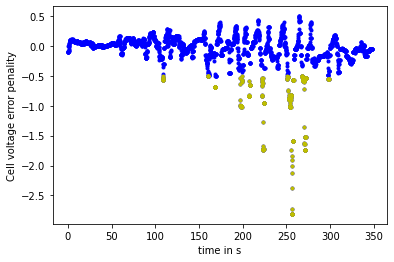

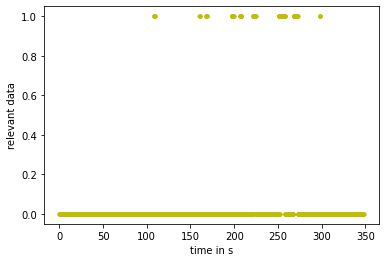

In [35]:
plt.clf()
plt.plot(time_vec,thr_vec*SCALE_THR, 'b.', label='Actual values')
plt.xlabel('time in s')
plt.ylabel('Throttle in 0.1%')
plt.show()

plt.clf()
plt.plot(time_vec,curr_vec_gt*SCALE_CUR, 'b.', label='Actual values')
plt.plot(time_vec,curr_vec*SCALE_CUR, 'r.', label='TF predicted')
plt.legend()
plt.xlabel('time in s')
plt.ylabel('Current in A')
plt.show()

plt.clf()
plt.plot(time_vec,cap_vec_gt*SCALE_CAP, 'b.', label='Actual values')
plt.plot(time_vec,cap_vec*SCALE_CAP, 'r.', label='TF predicted and accumulated')
plt.legend()
plt.xlabel('time in s')
plt.ylabel('Capacity in mAh')
plt.show()

plt.clf()
plt.plot(time_vec,vol_vec_gt*SCALE_VOL/NUM_CEL, 'b.', label='Actual values')
plt.plot(time_vec,vol_vec*SCALE_VOL/NUM_CEL, 'r.', label='TF predicted')
plt.plot(time_vec[curate>0],vol_vec_gt[curate>0]*SCALE_VOL/NUM_CEL, 'y.', label='relevant')
plt.ylim(3.4, 3.8)
plt.legend()
plt.xlabel('time in s')
plt.ylabel('Cell voltage in V')
plt.show()

plt.clf()
plt.plot(time_vec,cell_vol_penality, 'b.')
plt.plot(time_vec[curate>0],cell_vol_penality[curate>0], 'y.')
plt.xlabel('time in s')
plt.ylabel('Cell voltage error penality')
plt.show()

plt.clf()
plt.plot(time_vec,curate, 'y.')
plt.xlabel('time in s')
plt.ylabel('relevant data')
plt.show()

# Data Curation


penality sum: -207


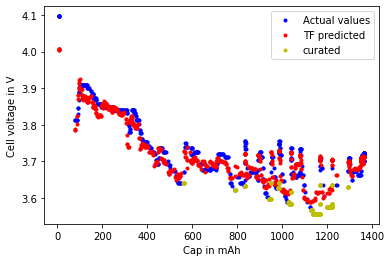

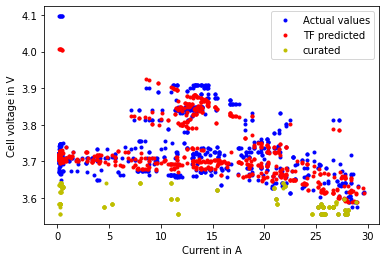

In [36]:
print('penality sum:',str(int(sum(cell_vol_penality[curate>0]))))
curate = np.array(curate,dtype='bool')

thr_vec_relevant=thr_vec[curate]
curr_vec_gt_relevant=curr_vec_gt[curate]
cap_vec_gt_relevant=cap_vec_gt[curate]
vol_vec_gt_relevant=vol_vec_gt[curate]

# Plot vol vs. cap
plt.plot(x_test[:,1]*SCALE_CAP, y_test*SCALE_VOL/NUM_CEL, 'b.', label='Actual values')
plt.plot(x_test[:,1]*SCALE_CAP, y_test_pred*SCALE_VOL/NUM_CEL, 'r.', label='TF predicted')
plt.plot(cap_vec_gt_relevant*SCALE_CAP, vol_vec_gt_relevant*SCALE_VOL/NUM_CEL, 'y.', label='curated')
plt.legend()
plt.xlabel('Cap in mAh')
plt.ylabel('Cell voltage in V')
plt.show()

# Plot vol vs. cap
plt.plot(x_test[:,0]*SCALE_CUR, y_test*SCALE_VOL/NUM_CEL, 'b.', label='Actual values')
plt.plot(x_test[:,0]*SCALE_CUR, y_test_pred*SCALE_VOL/NUM_CEL, 'r.', label='TF predicted')
plt.plot(curr_vec_gt_relevant*SCALE_CUR, vol_vec_gt_relevant*SCALE_VOL/NUM_CEL, 'y.', label='curated')
plt.legend()
plt.xlabel('Current in A')
plt.ylabel('Cell voltage in V')
plt.show()


In [37]:
#define data for modelling

cur_values_curate=cur_values
cap_values_curate=cap_values
cel_values_curate=cel_values

cur_values_curate=np.append(cur_values_curate,curr_vec_gt_relevant)
cap_values_curate=np.append(cap_values_curate,cap_vec_gt_relevant)
cel_values_curate=np.append(cel_values_curate,vol_vec_gt_relevant)

x_values=np.vstack((cur_values_curate,cap_values_curate))
x_values=np.transpose(x_values)
y_values=cel_values_curate